# SE DER TEMPO:
- PADRONIZAR DADOS DE BENEFICIÁRIOS PARA 2021 SÓ PRA ESTADOS NECESSÁRIOS!!
- ANALISAR REDE DE SAÚDE DE SP E RJ
- DEFINIR NOME DA MÉTRICA proporcao_bh_apoio

# **Install and import of necessary libraries:**

In [ ]:
# installing necessary libraries that are not already installed by default on Google Colab:

# library to read .ods files:
!pip install odfpy;
print('')
print('===============')
print('')

# library to read datasets directly from Google Big Query:
!pip install basedosdados;
#!pip install google-resumable-media
#!pip install --upgrade googleapis-common-protos
print('')
print('===============')
print('')

# library to make more advanced data visualizations:
!pip install plotly_express;

In [ ]:
# importing libraries:

# basic libraries:
import numpy as np
import pandas as pd

# data import libraries:
import basedosdados as bd
from google.colab import drive
import glob

# data visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px # bubble chart

# **Declaration of functions:**

In [ ]:
def gera_df_pop(drive_path):

    df_municipio = pd.read_excel(f'{drive_path}/datasets/planilhas_municipios/RELATORIO_DTB_BRASIL_MUNICIPIO.ods')

    df_populacao = pd.read_csv(f'{drive_path}/datasets/planilhas_populacao/populacao.csv')

    df = pd.merge(left=df_populacao, right=df_municipio, how='inner', left_on='id_municipio', right_on='Código Município Completo')

    cols = [
        'ano', 'id_municipio', 'Nome_Município', 'Nome_UF',
        'Nome Região Geográfica Intermediária', 'Nome Região Geográfica Imediata', 'Nome_Mesorregião', 'Nome_Microrregião',
        'sexo', 'grupo_idade', 'populacao'
    ]
    df = df[cols]

    df.columns = [
        'ano', 'id_municipio', 'nome_municipio', 'uf',
        'regiao_intermediaria', 'regiao_imediata', 'mesorregiao', 'microrregiao',
        'genero', 'grupo_idade', 'populacao'
    ]

    # pegando apenas os 6 primeiros digitos do id, pra poder cruzar com os outros datasets:
    df['id_municipio'] = df['id_municipio'].apply(lambda x: str(x)[0:6])

    return df

def consolida_populacao_por_municipio(drive_path):

    df = gera_df_pop(drive_path)

    group_cols = ['ano', 'id_municipio', 'uf', 'regiao_intermediaria', 'regiao_imediata', 'mesorregiao', 'microrregiao', 'nome_municipio']

    df_group = df.groupby(by=group_cols, as_index=False).agg({
        'populacao': ['count', 'sum', 'mean', 'median', 'std']
    })

    df_group.columns = df_group.columns.droplevel(0)
    group_cols.extend(['qtde', 'pop_total', 'pop_media', 'pop_mediana', 'pop_std'])
    df_group.columns = group_cols

    return df_group


###############################

def gera_df_beneficiarios(file_path):

    df_beneficiarios = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1')
    df_beneficiarios['CD_MUNICIPIO'] = df_beneficiarios['CD_MUNICIPIO'].astype(str)
    df_beneficiarios = df_beneficiarios.query("DT_INCLUSAO < '2022-01'")

    return df_beneficiarios


def consolida_beneficiarios_por_municipio(file_path):

    df = gera_df_beneficiarios(file_path)

    df_group = df.groupby(by=['CD_MUNICIPIO'], as_index=False).agg({
        'CD_OPERADORA': ['count', 'nunique'],
        'DT_INCLUSAO': ['nunique', 'min', 'max']
    })

    df_group.columns = df_group.columns.droplevel(0)
    df_group.columns = ['id_municipio', 'qtde_beneficiarios', 'qtde_operadoras', 'qtde_datas', 'min_data', 'max_data']
    df_group['file_path'] = file_path

    return df_group

def junta_beneficiarios_todos_estados(drive_path):

    all_files = glob.glob(f'{drive_path}/SIB/sib_202203_[PGEMB]*.csv')

    df = pd.DataFrame()
    for file_path in all_files:
        df_temp = consolida_beneficiarios_por_municipio(file_path)

        df = pd.concat([df, df_temp], axis=0, ignore_index=True)

    #df = pd.concat((consolida_beneficiarios_por_municipio(file_path) for file_path in all_files))

    return df

###############################

def gera_df_estabelecimentos(drive_path):

    df_estabelecimentos = pd.read_csv(f'{drive_path}/CNES/bq-results-20220702-123105-1656765097865.csv')
    df_estabelecimentos['id_municipio_6'] = df_estabelecimentos['id_municipio_6'].astype(str)

    return df_estabelecimentos


def consolida_estabelecimentos_por_municipio(drive_path):

    df = gera_df_estabelecimentos(drive_path)

    df_group = df.groupby(by=['id_municipio_6'], as_index=False).agg({
        'id_cnes': ['count'],
        'tipo_unidade': ['nunique']
    })
    df_group.columns = df_group.columns.droplevel(0)
    df_group.columns = ['id_municipio', 'qtde_estabelecimentos', 'qtde_tipos']

    return df_group


###############################


def gera_df_pib(drive_path):

    df_pib = pd.read_csv(f'{drive_path}/PIB_Municipios_2019.csv', sep=';')
    df_pib['PIB_PRC_CORRENTE'] = df_pib['PIB_PRC_CORRENTE'].apply(lambda x: x.replace('.', '').replace(',', '.'))
    df_pib['PIB_PERCAPITA_PRC_CORRENTE'] = df_pib['PIB_PERCAPITA_PRC_CORRENTE'].apply(lambda x: x.replace('.', '').replace(',', '.'))

    df_pib['PIB_PRC_CORRENTE'] = df_pib['PIB_PRC_CORRENTE'].astype(float)
    df_pib['PIB_PERCAPITA_PRC_CORRENTE'] = df_pib['PIB_PERCAPITA_PRC_CORRENTE'].astype(float)

    df_pib['COD_MUNICIPIO'] = df_pib['COD_MUNICIPIO'].astype(str)
    df_pib['COD_MUNICIPIO_6'] = df_pib['COD_MUNICIPIO_6'].astype(str)

    df_pib.drop(['ANO', 'COD_MUNICIPIO'], axis=1, inplace=True)
    df_pib.columns = ['id_municipio', 'valor_pib', 'pib_per_capita']

    return df_pib


###############################

def junta_datasets(df_pop, df_beneficiarios, df_estabelecimentos, df_pib, ano=2021):

    df_pop = df_pop.query(f"ano == {ano}")

    df_merge = pd.merge(left=df_pop, right=df_beneficiarios, how='left', on='id_municipio')

    df_merge = pd.merge(left=df_merge, right=df_estabelecimentos, how='left', on='id_municipio')

    df_final = pd.merge(left=df_merge, right=df_pib, how='left', on='id_municipio')


    df_final['proporcao_beneficiarios'] = df_final['qtde_beneficiarios'] / df_final['pop_total'] * 100
    df_final['cidadao_por_hospital'] = df_final['pop_total'] / df_final['qtde_estabelecimentos']
    df_final['beneficiario_por_hospital'] = df_final['qtde_beneficiarios'] / df_final['qtde_estabelecimentos']

    cols = [
        'id_municipio', 'uf', 'nome_municipio', 'regiao_intermediaria', 'regiao_imediata', 'mesorregiao', 'microrregiao',
        'pop_total', 'qtde_beneficiarios', 'qtde_operadoras', 'proporcao_beneficiarios',
        'qtde_estabelecimentos', 'cidadao_por_hospital', 'beneficiario_por_hospital',
        'valor_pib', 'pib_per_capita'
    ]
    df_final = df_final[cols]

    return df_final


###############################

def monta_abt(drive_path):

    df_pop = consolida_populacao_por_municipio(drive_path)
    df_beneficiarios = junta_beneficiarios_todos_estados(drive_path)
    df_estabelecimentos = consolida_estabelecimentos_por_municipio(drive_path)
    df_pib = gera_df_pib(drive_path)

    df = junta_datasets(df_pop, df_beneficiarios, df_estabelecimentos, df_pib, ano=2021)

    return df


def pivot_pop_por_genero(df):

    df_pivot_genero = pd.pivot_table(df, values='populacao', index=['id_municipio'],
                        columns=['genero'], aggfunc=np.sum)

    df_pivot_genero.columns = [col for col in df_pivot_genero.columns]
    df_pivot_genero.reset_index(inplace=True)
    df_pivot_genero['id_municipio'] = df_pivot_genero['id_municipio'].astype(str)

    return df_pivot_genero


def pivot_pop_por_idade(df):

    df_pivot_idade = pd.pivot_table(df, values='populacao', index=['id_municipio'],
                        columns=['grupo_idade'], aggfunc=np.sum)

    df_pivot_idade.columns = [col for col in df_pivot_idade.columns]
    df_pivot_idade.reset_index(inplace=True)
    df_pivot_idade['id_municipio'] = df_pivot_idade['id_municipio'].astype(str)

    return df_pivot_idade


def pivot_beneficiario_por_genero(df):

    df_pivot_genero = pd.pivot_table(df, values='LG_BENEFICIARIO_ATIVO', index=['CD_MUNICIPIO'],
                        columns=['TP_SEXO'], aggfunc=np.sum) #, margins=True)

    df_pivot_genero.columns = [col for col in df_pivot_genero.columns]
    df_pivot_genero.reset_index(inplace=True)
    df_pivot_genero.columns = ['id_municipio', 'qtde_beneficiarios_feminino', 'qtde_beneficiarios_masculino']
    df_pivot_genero['id_municipio'] = df_pivot_genero['id_municipio'].astype(str)

    return df_pivot_genero


def pivot_estabelecimento_por_tipo(df):

    df_pivot_tipo = pd.pivot_table(df, values='id_cnes', index=['id_municipio'],
                        columns=['nome_tipo_unidade'], aggfunc='count', fill_value=0)

    df_pivot_tipo.columns = [col for col in df_pivot_tipo.columns]
    df_pivot_tipo.reset_index(inplace=True)
    df_pivot_tipo['id_municipio'] = df_pivot_tipo['id_municipio'].astype(str)

    return df_pivot_tipo



# **Initial setup:**

In [ ]:
# connecting to my Google Drive:
drive.mount('/gdrive')

drive_path = '/gdrive/.shortcut-targets-by-id/1MNI7W_hrAxnm_EKmmeJI9LKcTUIegu2U/ASN.ROCKS'

Mounted at /gdrive


In [ ]:
df_abt_basica = monta_abt(drive_path)

In [ ]:
df_abt_basica.head()

,id_municipio,uf,nome_municipio,regiao_intermediaria,regiao_imediata,mesorregiao,microrregiao,pop_total,qtde_beneficiarios,qtde_operadoras,proporcao_beneficiarios,qtde_estabelecimentos,cidadao_por_hospital,beneficiario_por_hospital,valor_pib,pib_per_capita
0,110001,Rondônia,Alta Floresta D'Oeste,Ji-Paraná,Cacoal,Leste Rondoniense,Cacoal,22516,NaN,NaN,NaN,36,625.444444,NaN,495629.0,21600.73
1,110002,Rondônia,Ariquemes,Porto Velho,Ariquemes,Leste Rondoniense,Ariquemes,111148,NaN,NaN,NaN,151,736.079470,NaN,2578830.0,23908.38
2,110003,Rondônia,Cabixi,Ji-Paraná,Vilhena,Leste Rondoniense,Colorado do Oeste,5067,NaN,NaN,NaN,11,460.636364,NaN,139959.0,26347.78
3,110004,Rondônia,Cacoal,Ji-Paraná,Cacoal,Leste Rondoniense,Cacoal,86416,NaN,NaN,NaN,395,218.774684,NaN,2260644.0,26483.95
4,110005,Rondônia,Cerejeiras,Ji-Paraná,Vilhena,Leste Rondoniense,Colorado do Oeste,16088,NaN,NaN,NaN,25,643.520000,NaN,506854.0,31051.55


In [ ]:
df_pop = gera_df_pop(drive_path)
df_pop.sample(5)

,ano,id_municipio,nome_municipio,uf,regiao_intermediaria,regiao_imediata,mesorregiao,microrregiao,genero,grupo_idade,populacao
2537150,2020,351200,Colina,São Paulo,Ribeirão Preto,Barretos,Ribeirão Preto,Barretos,feminino,10-14 anos,558
980623,2021,250540,Desterro,Paraíba,Patos,Patos,Sertão Paraibano,Serra do Teixeira,masculino,70-74 anos,106
827590,2008,240325,Parnamirim,Rio Grande do Norte,Natal,Natal,Leste Potiguar,Natal,feminino,75-79 anos,824
1618077,2004,292820,Santana,Bahia,Barreiras,Barreiras,Extremo Oeste Baiano,Santa Maria da Vitória,masculino,45-49 anos,605
1415958,2021,290590,Campo Alegre de Lourdes,Bahia,Juazeiro,Juazeiro,Vale São-Franciscano da Bahia,Juazeiro,feminino,70-74 anos,418


In [ ]:
df_pop_2021 = df_pop.query("ano == 2021")
df_pivot_genero = pivot_pop_por_genero(df_pop_2021)
df_pivot_idade = pivot_pop_por_idade(df_pop_2021)

df_pivot_pop = pd.merge(left=df_pivot_genero, right=df_pivot_idade, how='inner', on='id_municipio')
df_pivot_pop.head()

,id_municipio,feminino,masculino,0-4 anos,10-14 anos,15-19 anos,20-24 anos,25-29 anos,30-34 anos,35-39 anos,40-44 anos,45-49 anos,5-9 anos,50-54 anos,55-59 anos,60-64 anos,65-69 anos,70-74 anos,75-79 anos,80-mais
0,110001,11013,11503,1601,1556,1623,1742,1910,1796,1772,1595,1506,1592,1497,1404,1039,743,478,334,328
1,110002,55652,55496,8396,8317,9490,10223,9877,9662,9160,8089,7071,8262,6487,5208,3939,2870,1862,1129,1106
2,110003,2486,2581,379,332,292,338,386,344,410,397,388,375,376,323,267,192,117,74,77
3,110004,44102,42314,5846,6065,6412,7005,7386,7560,7066,6506,5868,5939,5398,4679,3772,2737,1809,1130,1238
4,110005,8168,7920,1068,1077,1094,1232,1362,1361,1287,1183,1071,1097,1091,1038,759,504,373,244,247


In [ ]:
df_beneficiarios = pd.read_csv(f'{drive_path}/SIB/sib_202203_MG.csv', sep=';', encoding='ISO-8859-1')
df_beneficiarios['CD_MUNICIPIO'] = df_beneficiarios['CD_MUNICIPIO'].astype(str)
df_beneficiarios.head()

,ID_TEMPO_COMPETENCIA,CD_OPERADORA,DT_INCLUSAO,CD_BENE_MOTV_INCLUSAO,IND_PORTABILIDADE,ID_MOTIVO_MOVIMENTO,LG_BENEFICIARIO_ATIVO,DT_NASCIMENTO,TP_SEXO,CD_PLANO_RPS,...,CD_MUNICIPIO,SG_UF,LG_RESIDE_EXTERIOR,DT_REATIVACAO,DT_ULTIMA_REATIVACAO,DT_ULTIMA_MUDA_CONTRATUAL,DT_CANCELAMENTO,DT_ULTIMO_CANCELAMENTO,CD_BENE_MOTIV_CANCELAMENTO,DT_CARGA
0,202203,309401,1999-11,NaN,NAO,NaN,1,1947.0,F,423317994.0,...,312770,MG,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-05
1,202203,309401,2002-04,NaN,NAO,NaN,1,1938.0,F,NaN,...,312770,MG,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-05
2,202203,309401,1999-12,NaN,NAO,NaN,1,1948.0,F,NaN,...,312770,MG,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-05
3,202203,309401,1999-12,NaN,NAO,22.0,1,1954.0,F,NaN,...,312770,MG,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-05
4,202203,309401,2000-11,NaN,NAO,74.0,1,1962.0,M,417021991.0,...,312770,MG,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-05


In [ ]:
df_beneficiarios['DT_INCLUSAO'].value_counts(dropna=False)

2021-10    294455
2022-01    262756
2022-03    243345
2022-04    241928
2022-02    233657
            ...  
2000-03       856
2003-02       753
2000-05       437
2000-02       345
1999-01         1
Name: DT_INCLUSAO, Length: 270, dtype: int64

In [ ]:
df_pivot_beneficiario = pivot_beneficiario_por_genero(df_beneficiarios)
df_pivot_beneficiario.head()

,id_municipio,qtde_beneficiarios_feminino,qtde_beneficiarios_masculino
0,310000,360,330
1,310010,964,1171
2,310020,2260,2065
3,310030,491,534
4,310040,164,273


In [ ]:
df_pib = gera_df_pib(drive_path)
df_pib.head()

,id_municipio,valor_pib,pib_per_capita
0,110001,495629.0,21600.73
1,110002,2578830.0,23908.38
2,110003,139959.0,26347.78
3,110004,2260644.0,26483.95
4,110005,506854.0,31051.55


In [ ]:
df_pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_municipio    5570 non-null   object 
 1   valor_pib       5570 non-null   float64
 2   pib_per_capita  5570 non-null   float64
dtypes: float64(2), object(1)
memory usage: 130.7+ KB


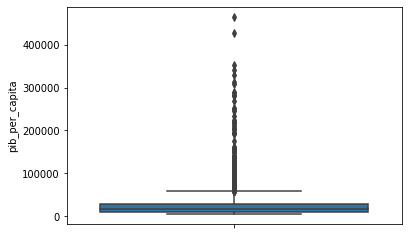

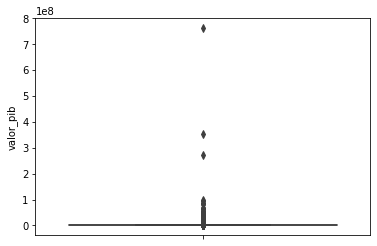

In [ ]:
sns.boxplot(data=df_pib, y='pib_per_capita');
plt.show()

sns.boxplot(data=df_pib, y='valor_pib');
plt.show()

In [ ]:
df_estabelecimentos = gera_df_estabelecimentos(drive_path)
df_estabelecimentos = df_estabelecimentos[[
    'id_municipio_6', 'vinculo_sus', 'tipo_unidade', 'id_cnes', 'cnpj_mantenedora',
    'atendimento_internacao_particular', 'atendimento_amb_particular'
]]
df_estabelecimentos.rename({'id_municipio_6': 'id_municipio'}, inplace=True, axis=1)
df_estabelecimentos.head()

,id_municipio,vinculo_sus,tipo_unidade,id_cnes,cnpj_mantenedora,atendimento_internacao_particular,atendimento_amb_particular
0,120001,1,70,153281,84306737000127,0,0
1,120001,1,2,257184,84306737000127,0,0
2,120001,1,4,258555,84306737000127,0,0
3,120001,1,50,271438,84306737000127,0,0
4,120001,1,84,282235,84306737000127,0,0


In [ ]:
df_estabelecimentos['atendimento_amb_particular'].value_counts(dropna=False)

1    228197
0    123044
Name: atendimento_amb_particular, dtype: int64

In [ ]:
df_tipo_unidade = pd.read_csv(f'{drive_path}/bq-results-20220702-130407-1656767071622.csv')
df_tipo_unidade = df_tipo_unidade[['chave', 'valor']]
df_tipo_unidade.columns = ['tipo_unidade', 'nome_tipo_unidade']
df_tipo_unidade.head()

,tipo_unidade,nome_tipo_unidade
0,1,Posto de Saúde
1,2,Centro de Saúde/Unidade Básica de Saúde
2,4,Policlínica
3,5,Hospital Geral
4,7,Hospital Especializado


In [ ]:
df_estabelecimentos = pd.merge(left=df_estabelecimentos, right=df_tipo_unidade, how='left', on='tipo_unidade')
df_estabelecimentos.head()

,id_municipio,vinculo_sus,tipo_unidade,id_cnes,cnpj_mantenedora,atendimento_internacao_particular,atendimento_amb_particular,nome_tipo_unidade
0,120001,1,70,153281,84306737000127,0,0,Centro de Atenção Psicossocial
1,120001,1,2,257184,84306737000127,0,0,Centro de Saúde/Unidade Básica de Saúde
2,120001,1,4,258555,84306737000127,0,0,Policlínica
3,120001,1,50,271438,84306737000127,0,0,Unidade de Vigilância em Saúde
4,120001,1,84,282235,84306737000127,0,0,NaN


In [ ]:
df_estabelecimentos['nome_tipo_unidade'].value_counts(dropna=False)

Consultório Isolado                                          164194
Clínica Especializada/Ambulatório Especializado               53584
Centro de Saúde/Unidade Básica de Saúde                       39005
Unidade de Serviços de Apoio de Diagnose e Terapia            26545
Policlínica                                                   10000
Farmácia                                                       9266
Posto de Saúde                                                 8952
Secretária de Saúde                                            6022
NaN                                                            5738
Hospital Geral                                                 5412
Unidade Móvel de Nível Pré-Hospitalar na área de Urgência      4747
Centro de Atenção Psicossocial                                 3185
Polo Academia da Saúde                                         3068
Unidade de Vigilância em Saúde                                 2618
Pronto Atendimento                              

In [ ]:
lista_tipos = [
    'Clínica Especializada/Ambulatório Especializado',
    'Centro de Saúde/Unidade Básica de Saúde',
    'Posto de Saúde',
    'Hospital Geral',
    'Pronto Atendimento',
    'Hospital Especializado',
    'Centro de Apoio a Saúde da Família',
    'Pronto Socorro Geral',
    'Pronto Socorro Especializado',
    'Unidade de Serviços de Apoio de Diagnose e Terapia',
    'Hospital/Dia Isolado'
]

In [ ]:
#df_temp = df_estabelecimentos.query(f"nome_tipo_unidade in {tuple(lista_tipos)}")

df_pivot_estabelecimento = pivot_estabelecimento_por_tipo(df_estabelecimentos)
df_pivot_estabelecimento.head()

,id_municipio,Central de Regulação Média de Urgências,Central de Regulação de Serviços de Saúde,Centro de Apoio a Saúde da Família,Centro de Atenção Hemoterápica e/ou Hematológica,Centro de Atenção Psicossocial,Centro de Parto Normal Isolado,Centro de Saúde/Unidade Básica de Saúde,Clínica Especializada/Ambulatório Especializado,Consultório Isolado,...,Pronto Socorro Geral,Secretária de Saúde,Telessaúde,Unidade Mista,Unidade Móvel Fluvial,Unidade Móvel Terrestre,Unidade Móvel de Nível Pré-Hospitalar na área de Urgência,Unidade de Atenção a Saúde Indígena,Unidade de Serviços de Apoio de Diagnose e Terapia,Unidade de Vigilância em Saúde
0,110001,0,0,0,1,1,0,4,1,6,...,0,1,0,0,0,0,0,7,4,1
1,110002,1,0,1,1,1,0,13,37,48,...,0,2,0,0,0,0,6,0,15,4
2,110003,0,0,2,0,0,0,2,0,1,...,0,1,0,1,0,0,0,0,1,1
3,110004,0,0,0,3,1,0,11,50,227,...,1,2,0,0,0,2,0,11,17,3
4,110005,0,0,0,1,1,0,4,3,5,...,0,1,0,0,0,0,0,0,5,1


In [ ]:
df_abt = pd.merge(left=df_abt_basica, right=df_pivot_pop, how='left', on='id_municipio')
df_abt = pd.merge(left=df_abt, right=df_pivot_beneficiario, how='left', on='id_municipio')
df_abt = pd.merge(left=df_abt, right=df_pivot_estabelecimento, how='left', on='id_municipio')
df_abt.head()

,id_municipio,uf,nome_municipio,regiao_intermediaria,regiao_imediata,mesorregiao,microrregiao,pop_total,qtde_beneficiarios,qtde_operadoras,...,Pronto Socorro Geral,Secretária de Saúde,Telessaúde,Unidade Mista,Unidade Móvel Fluvial,Unidade Móvel Terrestre,Unidade Móvel de Nível Pré-Hospitalar na área de Urgência,Unidade de Atenção a Saúde Indígena,Unidade de Serviços de Apoio de Diagnose e Terapia,Unidade de Vigilância em Saúde
0,110001,Rondônia,Alta Floresta D'Oeste,Ji-Paraná,Cacoal,Leste Rondoniense,Cacoal,22516,NaN,NaN,...,0,1,0,0,0,0,0,7,4,1
1,110002,Rondônia,Ariquemes,Porto Velho,Ariquemes,Leste Rondoniense,Ariquemes,111148,NaN,NaN,...,0,2,0,0,0,0,6,0,15,4
2,110003,Rondônia,Cabixi,Ji-Paraná,Vilhena,Leste Rondoniense,Colorado do Oeste,5067,NaN,NaN,...,0,1,0,1,0,0,0,0,1,1
3,110004,Rondônia,Cacoal,Ji-Paraná,Cacoal,Leste Rondoniense,Cacoal,86416,NaN,NaN,...,1,2,0,0,0,2,0,11,17,3
4,110005,Rondônia,Cerejeiras,Ji-Paraná,Vilhena,Leste Rondoniense,Colorado do Oeste,16088,NaN,NaN,...,0,1,0,0,0,0,0,0,5,1


In [ ]:
df_abt.query("nome_municipio == 'Uberaba' ")

,id_municipio,uf,nome_municipio,regiao_intermediaria,regiao_imediata,mesorregiao,microrregiao,pop_total,qtde_beneficiarios,qtde_operadoras,...,Pronto Socorro Geral,Secretária de Saúde,Telessaúde,Unidade Mista,Unidade Móvel Fluvial,Unidade Móvel Terrestre,Unidade Móvel de Nível Pré-Hospitalar na área de Urgência,Unidade de Atenção a Saúde Indígena,Unidade de Serviços de Apoio de Diagnose e Terapia,Unidade de Vigilância em Saúde
3066,317010,Minas Gerais,Uberaba,Uberaba,Uberaba,Triângulo Mineiro/Alto Paranaíba,Uberaba,340277,179859.0,285.0,...,0,2,0,0,0,6,6,0,24,4


In [ ]:
df_profissionais = pd.read_csv(f'{drive_path}/profissional_cnes.csv')
df_profissionais.shape

(73206, 6)

In [ ]:
df_profissionais.head()

,ano,mes,id_municipio,id_municipio_6,codigo_conselho,qtde_profissional
0,2021,6,1200013,120001,77,2
1,2021,6,1200013,120001,NaN,132
2,2021,6,1200013,120001,66,36
3,2021,6,1200013,120001,70,2
4,2021,6,1200013,120001,74,2


In [ ]:
df_profissionais['codigo_conselho'].value_counts(dropna=False).head()

66     5570
NaN    5564
75     5559
71     5557
70     5488
Name: codigo_conselho, dtype: int64

In [ ]:
df_codigo = pd.read_csv(f'{drive_path}/cod_registro_conselho.csv', sep=';', encoding='ISO-8859-1')
df_codigo.rename({'cod_conselho_regional': 'codigo_conselho'}, axis=1, inplace=True)
df_codigo['codigo_conselho'] = df_codigo['codigo_conselho'].astype(str)
df_codigo.shape

(39, 2)

In [ ]:
df_codigo.head()

,codigo_conselho,conselho_regional
0,15,Conselho Regional de Biomedicina
1,17,Conselho Regional de Fonoaudiologia
2,18,Conselho Regional de Biologia
3,19,Conselho Regional de Educação Física
4,20,Conselho Regional de Economia


In [ ]:
df_codigo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   codigo_conselho    39 non-null     object
 1   conselho_regional  39 non-null     object
dtypes: object(2)
memory usage: 752.0+ bytes


In [ ]:
df_profissionais = pd.merge(left=df_profissionais, right=df_codigo, how='left', on='codigo_conselho')
df_profissionais = df_profissionais[['id_municipio_6', 'conselho_regional', 'qtde_profissional']]
df_profissionais.rename({'id_municipio_6': 'id_municipio'}, axis=1, inplace=True)
df_profissionais.head()

,id_municipio,conselho_regional,qtde_profissional
0,120001,Conselho Regional de Psicologia,2
1,120001,NaN,132
2,120001,Conselho Regional de Enfermagem,36
3,120001,Conselho Regional de Fisioterapia e Terapia O...,2
4,120001,Conselho Regional de Nutrição,2


In [ ]:
df_profissionais['conselho_regional'].unique().tolist()

[' Conselho Regional de Psicologia',
 nan,
 ' Conselho Regional de Enfermagem',
 ' Conselho Regional de Fisioterapia e Terapia Ocupacional',
 ' Conselho Regional de Nutrição',
 ' Conselho Regional de Odontologia',
 ' Conselho Regional de Medicina',
 ' Conselho Regional de Administração',
 ' Conselho Regional de Técnicos de Radiologia',
 ' Conselho Regional de Assistência Social',
 'Conselho Regional de Biomedicina',
 ' Outros Emissores',
 ' Registro do Ministério da Saúde - Programa Mais Médicos',
 ' Conselho Regional de Farmácia',
 ' Conselho Regional de Biologia',
 ' Conselho Regional de Fonoaudiologia',
 ' Conselho Regional de Educação Física',
 ' Documento Estrangeiro',
 ' Conselho Regional de Engenharia, Arquitetura e Agronomia',
 ' Conselho Regional de Medicina Veterinária',
 ' Carteira de Identidade Classista',
 ' Conselho Regional de Contabilidade',
 ' Conselho Regional de Economia',
 ' Conselho Regional de Radiologia',
 ' Conselho Regional de Estatística',
 ' Ordem dos Advogad

In [ ]:
df_profissionais['conselho_regional'].value_counts(dropna=False).head()

NaN                                                         7312
 Conselho Regional de Enfermagem                            5570
 Conselho Regional de Odontologia                           5559
 Conselho Regional de Medicina                              5557
 Conselho Regional de Fisioterapia e Terapia Ocupacional    5488
Name: conselho_regional, dtype: int64

In [ ]:
df_pivot_profissionais = pd.pivot_table(df_profissionais, values='qtde_profissional', index=['id_municipio'],
                        columns=['conselho_regional'], aggfunc='sum', fill_value=0)

df_pivot_profissionais.columns = [col for col in df_pivot_profissionais.columns]
df_pivot_profissionais.reset_index(inplace=True)
df_pivot_profissionais['id_municipio'] = df_pivot_profissionais['id_municipio'].astype(str)
df_pivot_profissionais

,id_municipio,Carteira de Identidade Classista,Comando da Aeronáutica (Ex Ministério da Aeronáutica),Comando da Marinha (Ex Ministério da Marinha),Comando do Exército (Ex Ministério do Exército),Conselho Regional de Administração,Conselho Regional de Assistência Social,Conselho Regional de Biblioteconomia,Conselho Regional de Biologia,Conselho Regional de Contabilidade,...,Conselho Regional de Técnicos de Radiologia,Conselho Regional de Ópticos,Documento Estrangeiro,Ordem dos Advogados do Brasil,Ordem dos Músicos do Brasil,Organismos Militares,Outros Emissores,Polícia Federal,Registro do Ministério da Saúde - Programa Mais Médicos,Conselho Regional de Biomedicina
0,110001,0,0,0,0,0,4,0,0,0,...,5,0,0,0,0,0,0,0,2,0
1,110002,0,11,0,0,3,8,0,0,0,...,13,0,0,0,0,0,0,0,3,12
2,110003,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,2
3,110004,0,0,0,0,2,31,0,1,0,...,40,0,0,0,0,0,3,0,12,17
4,110005,0,0,0,0,0,4,0,0,0,...,4,0,1,0,1,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,522200,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,3
5566,522205,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,4
5567,522220,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
5568,522230,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [ ]:
df_abt = pd.merge(left=df_abt, right=df_pivot_profissionais, how='left', on='id_municipio')
df_abt.head()

,id_municipio,uf,nome_municipio,regiao_intermediaria,regiao_imediata,mesorregiao,microrregiao,pop_total,qtde_beneficiarios,qtde_operadoras,...,Conselho Regional de Técnicos de Radiologia,Conselho Regional de Ópticos,Documento Estrangeiro,Ordem dos Advogados do Brasil,Ordem dos Músicos do Brasil,Organismos Militares,Outros Emissores,Polícia Federal,Registro do Ministério da Saúde - Programa Mais Médicos,Conselho Regional de Biomedicina
0,110001,Rondônia,Alta Floresta D'Oeste,Ji-Paraná,Cacoal,Leste Rondoniense,Cacoal,22516,NaN,NaN,...,5,0,0,0,0,0,0,0,2,0
1,110002,Rondônia,Ariquemes,Porto Velho,Ariquemes,Leste Rondoniense,Ariquemes,111148,NaN,NaN,...,13,0,0,0,0,0,0,0,3,12
2,110003,Rondônia,Cabixi,Ji-Paraná,Vilhena,Leste Rondoniense,Colorado do Oeste,5067,NaN,NaN,...,1,0,0,0,0,0,0,0,1,2
3,110004,Rondônia,Cacoal,Ji-Paraná,Cacoal,Leste Rondoniense,Cacoal,86416,NaN,NaN,...,40,0,0,0,0,0,3,0,12,17
4,110005,Rondônia,Cerejeiras,Ji-Paraná,Vilhena,Leste Rondoniense,Colorado do Oeste,16088,NaN,NaN,...,4,0,1,0,1,0,0,0,0,3


# **Exploratory Data Analysis (EDA):**

In [ ]:
df_abt.shape

(5570, 106)

In [ ]:
df = df_abt[df_abt['qtde_beneficiarios'].notna()]
df.shape

(3206, 106)

In [ ]:
df['qtde_beneficiarios'] = df['qtde_beneficiarios'].astype(int)
df['qtde_operadoras'] = df['qtde_operadoras'].astype(int)
df['proporcao_beneficiarios'] = df['proporcao_beneficiarios'].apply(lambda x: np.round(x, 2))
df['cidadao_por_hospital'] = df['cidadao_por_hospital'].astype(int)
df['beneficiario_por_hospital'] = df['beneficiario_por_hospital'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3206 entries, 151 to 5568
Columns: 106 entries, id_municipio to Conselho Regional de Biomedicina
dtypes: float64(5), int64(94), object(7)
memory usage: 2.6+ MB


In [ ]:
df.describe(exclude='object')

,pop_total,qtde_beneficiarios,qtde_operadoras,proporcao_beneficiarios,qtde_estabelecimentos,cidadao_por_hospital,beneficiario_por_hospital,valor_pib,pib_per_capita,feminino,...,Conselho Regional de Técnicos de Radiologia,Conselho Regional de Ópticos,Documento Estrangeiro,Ordem dos Advogados do Brasil,Ordem dos Músicos do Brasil,Organismos Militares,Outros Emissores,Polícia Federal,Registro do Ministério da Saúde - Programa Mais Médicos,Conselho Regional de Biomedicina
count,3.206000e+03,3.206000e+03,3206.000000,3206.000000,3206.000000,3206.000000,3206.00000,3.206000e+03,3206.000000,3.206000e+03,...,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000,3206.000000
mean,3.077685e+04,7.563495e+03,38.869619,8.988153,50.077979,819.768559,61.18247,8.112635e+05,21030.167162,1.567885e+04,...,5.866500,0.023082,0.060823,0.086400,0.014660,0.012477,3.882096,0.004991,0.932626,2.825016
std,1.088331e+05,5.956643e+04,40.360944,11.956066,219.000923,424.554485,88.49899,3.788987e+06,23891.710321,5.770232e+04,...,36.654021,0.196928,0.488603,0.742527,0.254942,0.147259,48.356926,0.078837,1.695497,18.789488
min,7.710000e+02,2.000000e+00,2.000000,0.030000,1.000000,134.000000,0.00000,1.551500e+04,4482.850000,3.560000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.802250e+03,1.432500e+02,17.000000,1.590000,8.000000,514.000000,12.00000,7.650200e+04,9271.497500,2.872500e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.198300e+04,4.325000e+02,27.000000,4.430000,15.000000,735.000000,32.00000,1.730780e+05,14088.510000,5.915000e+03,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.423400e+04,1.692500e+03,44.000000,11.465000,30.000000,1020.750000,73.00000,4.281468e+05,24703.190000,1.214300e+04,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
max,2.900319e+06,1.641238e+06,461.000000,196.590000,6730.000000,3685.000000,848.00000,9.720532e+07,464883.490000,1.567801e+06,...,1089.000000,4.000000,12.000000,22.000000,12.000000,4.000000,1936.000000,2.000000,19.000000,765.000000


In [ ]:
df.describe(include='object')

,id_municipio,uf,nome_municipio,regiao_intermediaria,regiao_imediata,mesorregiao,microrregiao
count,3206,3206,3206,3206,3206,3206,3206
unique,3206,12,3117,73,288,71,301
top,311700,Minas Gerais,Bonito,Juíz de Fora,Campina Grande,Sul/Sudoeste de Minas,Ilhéus-Itabuna
freq,1,853,4,146,47,146,41


In [ ]:
df['uf'].value_counts(dropna=False)

Minas Gerais          853
Bahia                 417
Paraná                399
Goiás                 246
Piauí                 224
Paraíba               223
Maranhão              217
Pernambuco            185
Pará                  144
Mato Grosso           141
Mato Grosso do Sul     79
Espírito Santo         78
Name: uf, dtype: int64

In [ ]:
df.columns.tolist()

['id_municipio',
 'uf',
 'nome_municipio',
 'regiao_intermediaria',
 'regiao_imediata',
 'mesorregiao',
 'microrregiao',
 'pop_total',
 'qtde_beneficiarios',
 'qtde_operadoras',
 'proporcao_beneficiarios',
 'qtde_estabelecimentos',
 'cidadao_por_hospital',
 'beneficiario_por_hospital',
 'valor_pib',
 'pib_per_capita',
 'feminino',
 'masculino',
 '0-4 anos',
 '10-14 anos',
 '15-19 anos',
 '20-24 anos',
 '25-29 anos',
 '30-34 anos',
 '35-39 anos',
 '40-44 anos',
 '45-49 anos',
 '5-9 anos',
 '50-54 anos',
 '55-59 anos',
 '60-64 anos',
 '65-69 anos',
 '70-74 anos',
 '75-79 anos',
 '80-mais',
 'qtde_beneficiarios_feminino',
 'qtde_beneficiarios_masculino',
 'Central de Regulação Média de Urgências',
 'Central de Regulação de Serviços de Saúde',
 'Centro de Apoio a Saúde da Família',
 'Centro de Atenção Hemoterápica e/ou Hematológica',
 'Centro de Atenção Psicossocial',
 'Centro de Parto Normal Isolado',
 'Centro de Saúde/Unidade Básica de Saúde',
 'Clínica Especializada/Ambulatório Especial

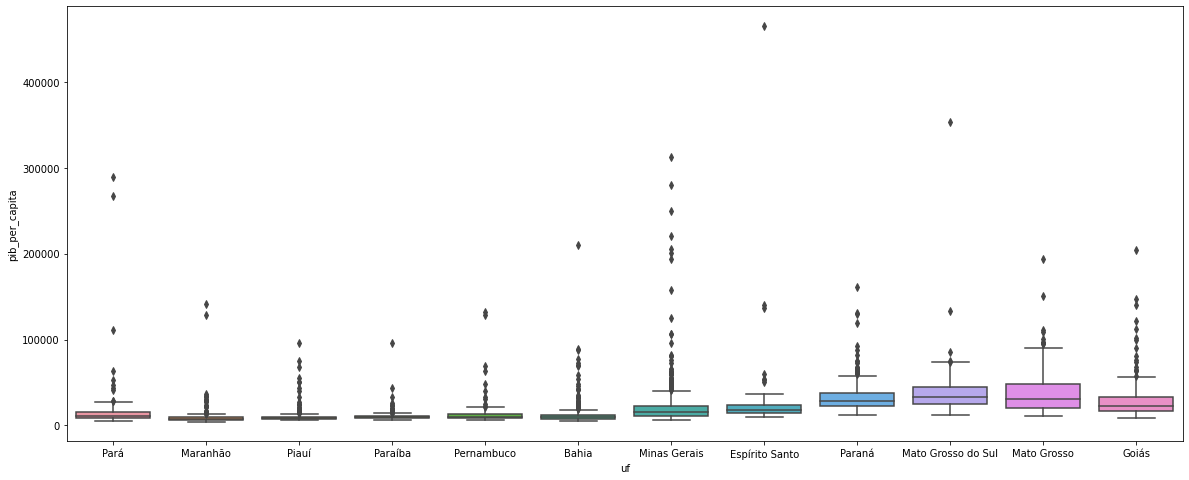

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(data=df, y='pib_per_capita', x='uf');
plt.show()

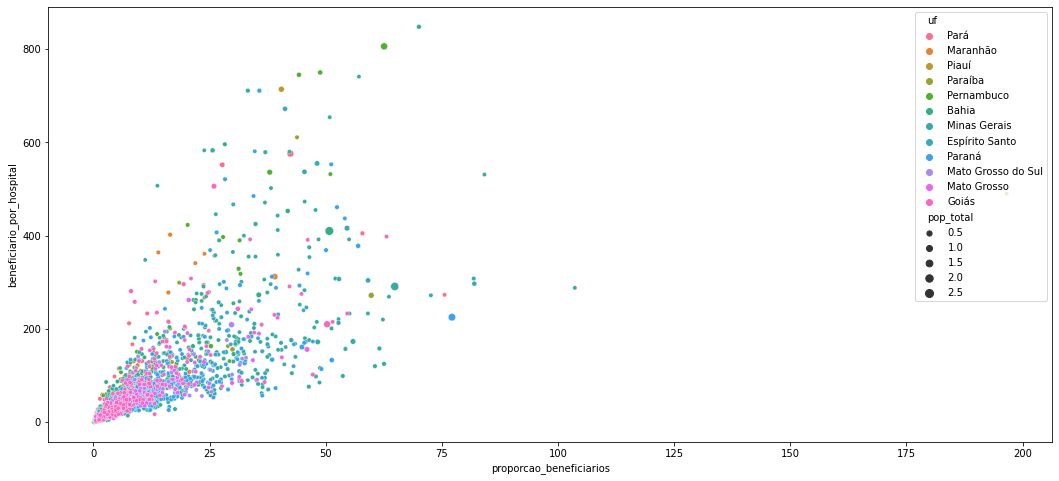

In [ ]:
plt.figure(figsize=(18,8))
sns.scatterplot(df['proporcao_beneficiarios'], df['beneficiario_por_hospital'], size=df['pop_total'], hue=df['uf']);
plt.show()

In [ ]:
#plt.figure(figsize=(18,8))
#sns.swarmplot(data=df.query("pop_total < 1000000"), y='pop_total'); #, x='mesorregiao');
#plt.show()

In [ ]:
df['proporcao_idosos'] = (df['60-64 anos']+df['65-69 anos']+df['70-74 anos']+df['75-79 anos']+df['80-mais'])/df['pop_total']*100
df['proporcao_idosos'] = df['proporcao_idosos'].apply(lambda x: np.round(x,2))

df['proporcao_ps'] = (df['Pronto Atendimento']+df['Pronto Socorro Especializado']+df['Pronto Socorro Geral'])/df['qtde_estabelecimentos']*100
df['proporcao_ps'] = df['proporcao_ps'].apply(lambda x: np.round(x,2))

df['proporcao_amb'] = df['Clínica Especializada/Ambulatório Especializado']/df['qtde_estabelecimentos']*100
df['proporcao_amb'] = df['proporcao_amb'].apply(lambda x: np.round(x,2))

df['qtde_hospitais'] = df['Hospital Especializado']+df['Hospital Geral']+df['Hospital/Dia Isolado']
df['proporcao_hospital'] = df['qtde_hospitais']/df['qtde_estabelecimentos']*100
df['proporcao_hospital'] = df['proporcao_hospital'].apply(lambda x: np.round(x,2))

df['proporcao_apoio'] = (df['Policlínica']+
                         df['Clínica Especializada/Ambulatório Especializado']+df['Unidade de Serviços de Apoio de Diagnose e Terapia']+
                         df['Unidade Móvel Terrestre']+df['Unidade Móvel de Nível Pré-Hospitalar na área de Urgência']+
                         df['Laboratório Central de Saúde Pública - LACEN']+df['Centro de Atenção Hemoterápica e/ou Hematológica']+
                         df['Polo Academia da Saúde']+df['Telessaúde']+df['Central de Regulação de Serviços de Saúde'])/df['pop_total']*1000
df['proporcao_apoio'] = df['proporcao_apoio'].apply(lambda x: np.round(x,2))

proporcao_apoio_bh = df.query("nome_municipio == 'Belo Horizonte' ")['proporcao_apoio'].item()
df['comparacao_bh_apoio'] = np.round((df['proporcao_apoio']/proporcao_apoio_bh)*100, 2)

df['qtde_profissionais'] = df[' Conselho Regional de Medicina']+df[' Conselho Regional de Psicologia']+df[' Conselho Regional de Enfermagem']+df[' Conselho Regional de Fisioterapia e Terapia Ocupacional']


df['proporcao_profissionais'] = df['qtde_profissionais']/df['pop_total']*1000
df['proporcao_profissionais'] = df['proporcao_profissionais'].apply(lambda x: np.round(x,1))


In [ ]:
df.columns.tolist()

In [ ]:
df_temp = df.query("uf in ('Minas Gerais') ") #, 'Espírito Santo', 'Bahia', 'Goiás')")

In [ ]:
lista_top10 = df_temp.query("uf == 'Minas Gerais' ").sort_values('pop_total', ascending=False).head(10)['id_municipio'].tolist()
lista_bottom10 = df_temp.query("uf == 'Minas Gerais' ").sort_values('pop_total', ascending=False).tail(10)['id_municipio'].tolist()

In [ ]:
df_mg = df_temp.query(f"id_municipio in {tuple(lista_top10)} or id_municipio in {tuple(lista_bottom10)}")

In [ ]:
fig = px.scatter(
    df_temp, x='comparacao_bh_apoio', y='proporcao_beneficiarios', opacity=0.8,
    size='pib_per_capita', color='regiao_intermediaria', hover_name='nome_municipio',
    title='Situação dos Municípios em 2021',
    log_x=False , color_discrete_sequence=px.colors.qualitative.Dark24,
    #range_x=[0, 4],
    #range_y=[0,100],
    size_max=30,
    labels=dict(
        proporcao_beneficiarios='Beneficiários (%)',
        uf='Estado',
        regiao_intermediaria='Região Intermediária',
        mesorregiao='Mesorregião',
        pop_total='Nº de habitantes',
        qtde_operadoras='Quantidade de operadoras',
        beneficiario_por_hospital='Nº beneficiários a cada 1 hospital',
        cidadao_por_hospital='Nº cidadãos a cada 1 hospital',
        proporcao_profissionais='Oferta de Profissionais de Saúde para cada 1000 pessoas',
        proporcao_apoio='Rede de Apoio (nº de estabelecimentos de apoio para cada 1 hospital)',
        pib_per_capita='PIB per capita (R$)',
        comparacao_bh_apoio='Tamanho da rede de apoio, em relação à BH (em %)'
    )
)

#fig.update_layout({
#    'plot_bgcolor': 'rgb(255, 255, 255)',
#    'paper_bgcolor': 'rgb(255, 255, 255)',
#})

fig.show()

In [ ]:
df_brasil = df.query("uf in ('Minas Gerais', 'Espírito Santo', 'Bahia', 'Goiás') ")

In [ ]:
fig = px.scatter(
    df_brasil, x='comparacao_bh_apoio', y='proporcao_beneficiarios', opacity=0.8,
    size='pib_per_capita', color='uf', hover_name='nome_municipio',
    title='Situação dos Municípios em 2021',
    log_x=False , color_discrete_sequence=px.colors.qualitative.Dark24,
    #range_x=[0, 4],
    #range_y=[0,100],
    size_max=30,
    labels=dict(
        proporcao_beneficiarios='Beneficiários (%)',
        uf='Estado',
        regiao_intermediaria='Região Intermediária',
        mesorregiao='Mesorregião',
        pop_total='Nº de habitantes',
        qtde_operadoras='Quantidade de operadoras',
        beneficiario_por_hospital='Nº beneficiários a cada 1 hospital',
        cidadao_por_hospital='Nº cidadãos a cada 1 hospital',
        proporcao_profissionais='Oferta de Profissionais de Saúde para cada 1000 pessoas',
        proporcao_apoio='Rede de Apoio (nº de estabelecimentos de apoio para cada 1000 pessoas)',
        pib_per_capita='PIB per capita (R$)',
        comparacao_bh_apoio='Tamanho da rede de apoio, em relação à BH (em %)'
    )
)

#fig.update_layout({
#    'plot_bgcolor': 'rgb(255, 255, 255)',
#    'paper_bgcolor': 'rgb(255, 255, 255)',
#})

fig.show()

In [ ]:
df_brasil.query("nome_municipio == 'Vitória'")['pop_total'].item()

369534

In [ ]:
# MG:

# Uberlandia / Uberaba
# Divinopolis
# Juiz de Fora

# ===========
# Fora de MG:

# Vitoria


In [ ]:
df.query("nome_municipio == 'Belo Horizonte' ")

,id_municipio,uf,nome_municipio,regiao_intermediaria,regiao_imediata,mesorregiao,microrregiao,pop_total,qtde_beneficiarios,qtde_operadoras,...,Polícia Federal,Registro do Ministério da Saúde - Programa Mais Médicos,Conselho Regional de Biomedicina,proporcao_idosos,proporcao_ps,proporcao_amb,proporcao_hospital,proporcao_apoio,qtde_profissionais,proporcao_profissionais
2309,310620,Minas Gerais,Belo Horizonte,Belo Horizonte,Belo Horizonte,Metropolitana de Belo Horizonte,Belo Horizonte,2530701,1911202,480,...,1,2,278,18.72,0.21,35.8,1.08,1.05,55054,2.18


In [ ]:
df['pib_per_capita'].describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99])

count      3206.000000
mean      21030.167162
std       23891.710321
min        4482.850000
1%         5954.255000
5%         6988.667500
10%        7690.810000
25%        9271.497500
50%       14088.510000
75%       24703.190000
90%       39155.420000
95%       52733.032500
99%      111167.412000
max      464883.490000
Name: pib_per_capita, dtype: float64

In [ ]:
df['pib_per_capita'].quantile(0.96)

58304.01399999999

In [ ]:
df_profissionais.query("id_municipio == 310620 ")

,id_municipio,conselho_regional,qtde_profissional
43445,310620,Conselho Regional de Medicina,19706
43446,310620,NaN,2165
43447,310620,Conselho Regional de Psicologia,1815
43448,310620,Conselho Regional de Farmácia,1339
43449,310620,Conselho Regional de Química,749
43450,310620,NaN,27200
43451,310620,Conselho Regional de Enfermagem,30641
43452,310620,Conselho Regional de Odontologia,4009
43453,310620,Conselho Regional de Medicina Veterinária,89
43454,310620,Conselho Regional de Nutrição,736


In [ ]:
df.query("uf == 'Espírito Santo'")['id_municipio'].astype(int).describe()

count        78.000000
mean     320290.205128
std         157.709116
min      320010.000000
25%      320162.500000
50%      320307.500000
75%      320428.750000
max      320530.000000
Name: id_municipio, dtype: float64

In [ ]:
#%%shell
#jupyter nbconvert --to html /content/Datathon_ASN_Montando_ABT_turbinada.ipynb

[NbConvertApp] Converting notebook /content/Datathon_ASN_Montando_ABT_turbinada.ipynb to html
/usr/local/lib/python3.7/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Writing 815409 bytes to /content/Datathon_ASN_Montando_ABT_turbinada.html
